# Markov Random Geometric Graph (MRGG):
# A Growth Model for Temporal Dynamic Networks

In [1]:
from MRGG.Graph import Graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc
import os
import time
import math

# 1) Basic applications of the algorithm on simulated data

#### We use the envelope and the latitude functions presented in Eq.(10) of the paper. We build a graph with $1500$ nodes and we run the algorithm SCCHEi. We select the dimension of our model using the slope heuristic. The figure below presents the evolution $\tilde R(\kappa)$ (as defined in Eq.(6)) with respect to $\kappa$. 

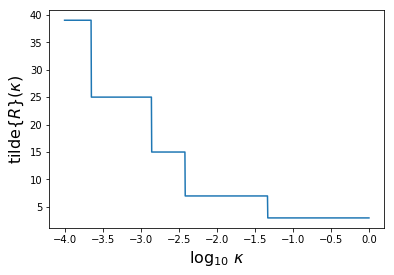

In [3]:
np.random.seed(2)
n = 1500
dimension = 3
G = Graph(n,dimension, sampling_type='markov',envelope='heaviside',latitude='mixture', sparsity = 1)
G.SCCHEi_with_R_search(listeR=[i for i in range(1,20)], figure=True)

### Visualization of the envelope and latitude functions (see figures provided in Section 1 of the paper)

##### Envelope function

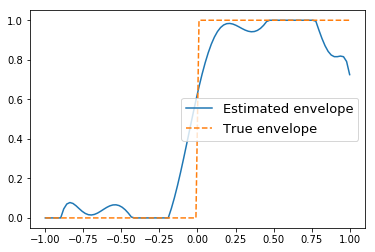

In [4]:
G.plot_estimation_envelope(savename='env-mix-hea.png')

##### Latitude function

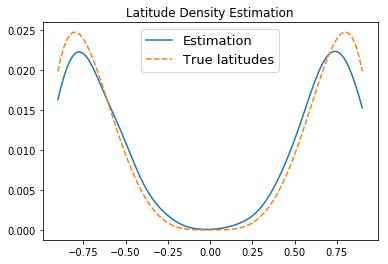

In [5]:
G.plot_densities_latitude(savename='lat-mix-hea.png')

### Clustering of the eigenvalues of the adjacency matrix

We plot the eigenvalues of the adjacency matrix of the graph with colors corresponding to clusters built by our algorithm SCCHEi.

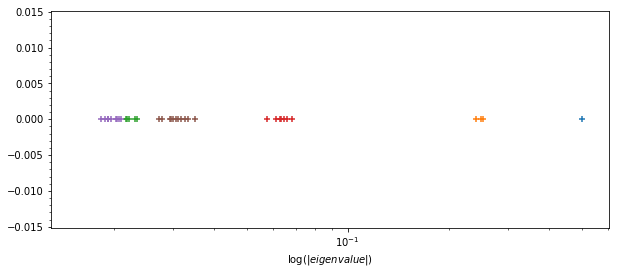

In [6]:
G.plot_eigenvalues_clusters_labeled(5)

In the following figure, we plot the eigenvalues $(p^*_k)_{k \geq 0}$ of the true envelope function $p$ and $(\hat{p}_k)_{k \geq 0}$ of the estimated envelope function (without multiplicity).

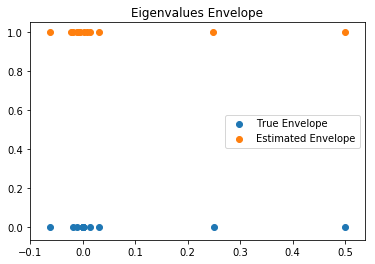

In [7]:
G.plot_comparison_eig_envelope()

In the following, we plot the eigenvalues of the adjacency matrix sorted in decreasing order of magnitude with blue crosses, while red diamonds present the spectrum $(\hat{p}_k)_{k \geq 0}$ (plotted with multiplicity) built using the algorithm SCCHEi.

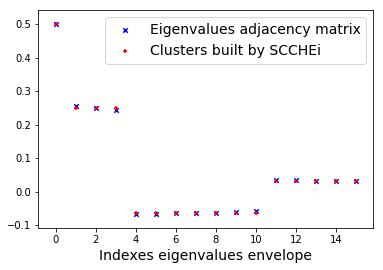

In [8]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(3)

# 2) Studying the performance of the algorithm with a size increasing

### /!\ You may need a cluster to launch the following script.

In [ ]:
def study_error(latitude,enveloppe):
    d = 3
    results  = {'error_enveloppe':[],'error_latitude':[],'size':[]}
    listen = list(map(int,np.logspace(np.log10(20),np.log10(1000),20)))
    for n in listen:
        for _ in range(7):
            G = Graph(n, d, sampling_type = 'markov', latitude = latitude, enveloppe = enveloppe)
            G.SCCHEi_with_R_search()
            results['error_enveloppe'].append(G.error_estimation_enveloppe())
            results['error_latitude'].append(G.error_estimation_latitude())
            results['size'].append(n)
    df = pd.DataFrame(results)
    df = df.apply(np.log10)
    return df

import seaborn as sns
def plot_errors(dataframe):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(121)
    sns.lineplot(x="size", y="error_enveloppe", err_style="bars", data=dataframe, ax = ax, label='Envelope')
    ax.set_xlabel('$\log \;n$', fontsize=16)
    ax.set_ylabel('$\log \;\delta_2(p^*,\hat{p})$', fontsize=16)
    ax.set_title('Estimation Error Envelope function', fontsize=16)
    plt.legend(fontsize=16)
    ax = fig.add_subplot(122)
    c = sns.lineplot(x="size", y="error_latitude", err_style="bars", data=dataframe, ax = ax, label='Latitude')
    c.lines[0].set_linestyle("--")
    ax.set_xlabel('$\log \; n$', fontsize=16)
    ax.set_ylabel('$\log \; \delta_2(f^*,\hat{f})$', fontsize=16)
    ax.set_title('Estimation Error Latitude function', fontsize=16)
    plt.legend(fontsize=16)
    plt.show()

In [ ]:
import pickle
df = study_error('mixture', 'heaviside')
plot_errors(df)

# 3) Relatively sparse regime

In [9]:
np.random.seed(2)
n = 1000
dimension = 3
t0 = time.time()
L = []
E = []
for k in [1,2,3,4]:
    G = Graph(n,dimension, sparsity = np.log(n)**k/n, sampling_type='markov',envelope='heaviside',latitude='mixture')
    x = np.linspace(-1,1,100)
    esti = list(map(G.latitude_estimator, x))
    esti /= sum(esti)
    L.append(esti)
    G.SCCHEi_with_R_search(listeR=[i for i in range(1,40)],listekappa=np.logspace(-4,0,1000), figure=False)
    esti = [G.estimation_envelope(xi) for xi in x]
    esti = list(map(lambda x:max(0,x),esti))
    esti = list(map(lambda x:min(1,x),esti))
    E.append(esti)
    print(time.time()-t0)

41.10713815689087
74.63593459129333
110.62941694259644
142.53927946090698


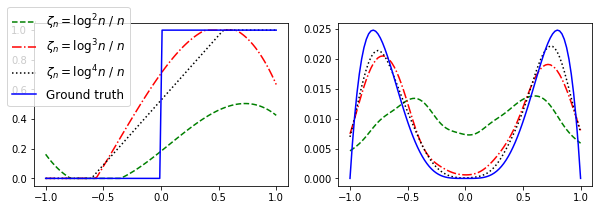

In [10]:
trueenv = [G.compute_envelope(xi) for xi in x]
true = np.array(list(map(G.density_latitude, x)))
fig, axes = plt.subplots(figsize=(10,3), ncols=2)
axes[0].plot(x, E[3], label='$\zeta_n= \log^2 n$ / $n$', c='green', linestyle='--')
axes[0].plot(x, E[2], label='$\zeta_n= \log^3 n$ / $n$', c='red', linestyle='-.')
axes[0].plot(x, E[1], label='$\zeta_n= \log^4 n$ / $n$', c='black', linestyle=':')
axes[0].plot(x, trueenv, label='Ground truth', c='blue', linestyle='-')
axes[1].plot(x, L[1], label='$\zeta_n= \log^4 n$ / $n$', c='green', linestyle='--')
axes[1].plot(x, L[2], label='$\zeta_n= \log^3 n$ / $n$', c='red', linestyle='-.')
axes[1].plot(x, L[3], label='$\zeta_n= \log^2 n$ / $n$', c='black', linestyle=':')
axes[1].plot(x, true/sum(true), label='Ground truth', c='blue', linestyle='-')
axes[0].legend(fontsize=12, bbox_to_anchor=(0.4,0.45))
#plt.savefig('relasparse2.png')

# 4) Link prediction

### a) Better than random

In [ ]:
risks = np.zeros((33,100,3))
import math
list_n = [100*i for i in range(10,16)]
NBRISK = 200
for indi,n in enumerate(list_n):
    print(n)
    nsamples = 40
    G = Graph(n, 3, sparsity = 1 ,sampling_type='markov',envelope='heaviside',latitude='concentrated')
    G.SCCHEi_with_R_search(listeR=[i for i in range(1,30)],listekappa=np.logspace(-4,0,1000), figure=False)
    eig, vec = np.linalg.eigh(G.A / (G.n * G.sparsity))
    G.latent_distance_estimation(G.sparsity * eig, vec, GRAM=True)    
    link_probas = np.zeros(n)
    link_probas_esti = np.zeros(n)
    for i in range(n-NBRISK,n):
        integral = 0
        discretize = np.linspace(-1,1,nsamples)
        true = np.array(list(map(G.density_latitude, discretize)))
        dense_lat = true/sum(true)
        for k,r_nnp in enumerate(discretize):
            for l,r_in in enumerate(discretize):
                density = dense_lat[k] / nsamples
                t = np.clip(G.gram[i,G.n-1],-1,1) * r_nnp + np.sqrt(1-r_nnp**2)*np.sqrt(1-np.clip(G.gram[i,G.n-1],-1,1)**2)*r_in
                m = density * G.compute_envelope(t)
                if not(math.isnan(m)):
                    integral += m
                else:
                    print('aie', np.sqrt(1-r_nnp**2)*np.sqrt(1-G.gram[i,G.n-1]**2))
        link_probas[i] = integral


        def find_closest(t,discretize):
            i = np.argmin(np.abs(discretize-t))
            return i

        integral = 0
        nsamples = 150
        discretize = np.linspace(-1,1,nsamples)
        esti = [G.estimation_envelope(xi) for xi in discretize]
        esti = list(map(lambda x:max(0,x),esti))
        esti = list(map(lambda x:min(1,x),esti))
        lat = np.array(list(map(G.latitude_estimator, discretize)))
        dense_lat = lat/sum(lat)
        for k,r_nnp in enumerate(discretize):
            for l,r_in in enumerate(discretize):
                density = dense_lat[k] / nsamples
                t = np.clip(G.gram[i,G.n-1],-1,1) * r_nnp + np.sqrt(1-r_nnp**2)*np.sqrt(1-np.clip(G.gram[i,G.n-1],-1,1)**2)*r_in
                m = density * esti[find_closest(t,discretize)]
                if not(math.isnan(m)):
                    integral += m
                else:
                    print('aie', np.sqrt(1-r_nnp**2)*np.sqrt(1-G.gram[i,G.n-1]**2))
        link_probas_esti[i] = integral
       
    p = np.sum(G.A) / n**2
    link_probas = link_probas[n-NBRISK:n]
    link_probas_esti = link_probas_esti[n-NBRISK:n]
    for k in range(100):
        Xnext = G.sample(G.V[:,G.n-1])
        envs = np.array(list(map(lambda x: G.compute_envelope(x), G.V.T @ Xnext)))
        envs = envs.reshape(-1)
        uniform = np.random.rand(G.n)
        A = 1*(uniform<envs)

        A=A[(len(A)-NBRISK):len(A)]

        risks[indi,k,0] = np.sum((np.ones(NBRISK)-link_probas) * A + link_probas * (np.ones(NBRISK)-A))
        risks[indi,k,1] = np.sum((1-p) * A + p * (np.ones(NBRISK)-A))
        risks[indi,k,2] = np.sum((np.ones(NBRISK)-link_probas_esti) * A + link_probas_esti * (np.ones(NBRISK)-A))

np.save('RISKS_concentrated.npy',risks)

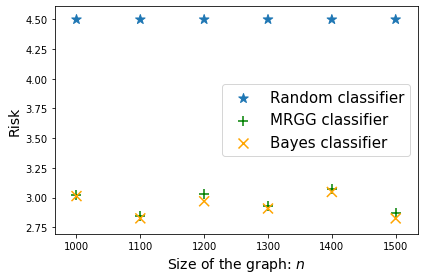

In [18]:
Liid = []
L = []
Lesti = []
limn = len(list_n)
for i in range(limn):
    Liid.append(np.mean(risks[i,:,1])/NBRISK)
    L.append(np.mean(risks[i,:,0])/NBRISK)
    Lesti.append(np.mean(risks[i,:,2])/NBRISK)

plt.scatter(list_n, Liid[:limn], marker='*',label='Random classifier',s=100*np.ones(limn))
plt.scatter(list_n, np.array(Lesti[:limn]),marker='+', c='green', label='MRGG classifier',s=100*np.ones(limn))
plt.scatter(list_n, np.array(L[:limn]),marker='x', c='orange', label='Bayes classifier',s=100*np.ones(limn))
plt.xlabel('Size of the graph: $n$',fontsize=14)
plt.ylabel('Risk',fontsize=14)
plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('link_prediction_concentrated.png',dpi=300)

### b) Link prediction on first 10 nodes

In [2]:
np.random.seed(2)
n = 1000
G = Graph(n, 3, sparsity = 1 ,sampling_type='markov',envelope='heaviside',latitude='concentrated')
G.SCCHEi_with_R_search(listeR=[i for i in range(1,30)],listekappa=np.logspace(-4,0,1000), figure=False)
eig, vec = np.linalg.eigh(G.A / (G.n * G.sparsity))
G.latent_distance_estimation(G.sparsity * eig, vec, GRAM=True)

##### Computation of the true integral (to compare with the empirical number of connections and they need to match)

In [3]:
def true_probas(nbnodes):        
    n = 1700
    nsamples = 40
    true_link_probas = np.zeros(nbnodes)
    GRAM = np.dot(G.V.T,G.V)
    for i in range(nbnodes):
        integral = 0
        discretize = np.linspace(-1,1,nsamples)
        true = np.array(list(map(G.density_latitude, discretize)))
        dense_lat = true/sum(true)
        for k,r_nnp in enumerate(discretize):
            for l,r_in in enumerate(discretize):
                density = dense_lat[k] / nsamples
                t = GRAM[i,G.n-1] * r_nnp + np.sqrt(1-r_nnp**2)*np.sqrt(1-GRAM[i,G.n-1]**2)*r_in
                integral += density * G.compute_envelope(t)
        print(i)
        true_link_probas[i] = integral
    return true_link_probas

true_link_probas = true_probas(10)

0
1
2
3
4
5
6
7
8
9


##### Estimation probabilities connections

In [4]:
def find_closest(t,discretize):
        i = np.argmin(np.abs(discretize-t))
        return i

def link_prediction(nbnodes):    
    n = 1000
    nsamples = 150
    link_probas = np.zeros(nbnodes)
    discretize = np.linspace(-1,1,nsamples)
    esti = [G.estimation_envelope(xi) for xi in discretize]
    esti = list(map(lambda x:max(0,x),esti))
    esti = list(map(lambda x:min(1,x),esti))
    for i in range(nbnodes):
        integral = 0
        true = np.array(list(map(G.latitude_estimator, discretize)))
        dense_lat = true/sum(true)
        for k,r_nnp in enumerate(discretize):
            for l,r_in in enumerate(discretize):
                density = dense_lat[k] / nsamples
                t = np.clip(G.gram[i,G.n-1],-1,1) * r_nnp + np.sqrt(1-r_nnp**2)*np.sqrt(1-np.clip(G.gram[i,G.n-1],-1,1)**2)*r_in
                integral += density * esti[find_closest(t,discretize)]
        print(i)
        link_probas[i] = integral
    return link_probas

link_probas = link_prediction(10)

0
1
2
3
4
5
6
7
8
9


##### Empirical number of connections (only to check the exact computation)

In [ ]:
pos = np.zeros(10)
nbite = 1000
ave = np.zeros(3)
for ite in range(nbite):
    Xnext = G.sample(G.V[:,G.n-1])
    pos += np.array(list(map(G.estimation_envelope, np.dot(G.V.T,Xnext)[:10])))
pos /= nbite

##### True link probability assuming iid samples on the sphere

In [5]:
def link_prediction_iid_case(nbnodes):    
    n = 1700
    nsamples = 40
    link_probas = np.zeros(nbnodes)
    for i in range(nbnodes):
        integral = 0
        discretize = np.linspace(-1,1,nsamples)
        for k,r_nnp in enumerate(discretize):
            for l,r_in in enumerate(discretize):
                density = 1 / nsamples**2
                t = np.clip(G.gram[i,G.n-1],-1,1) * r_nnp + np.sqrt(1-r_nnp**2)*np.sqrt(1-np.clip(G.gram[i,G.n-1],-1,1)**2)*r_in
                integral += density * G.compute_envelope(t)
        print(i)
        link_probas[i] = integral
    return link_probas

link_probas_iid_case = link_prediction_iid_case(10)

0
1
2
3
4
5
6
7
8
9


###### Figure

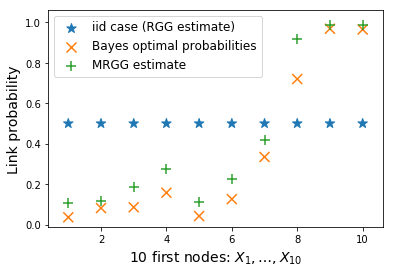

In [21]:
plt.figure(1)
ind = np.array([i for i in range(1,11)])
plt.scatter(ind, link_probas_iid_case.reshape(-1),marker='*', label='iid case (RGG estimate)',s=100*np.ones(10))
plt.scatter(ind, true_link_probas.reshape(-1),marker='x', label='Bayes optimal probabilities',s=100*np.ones(10))
plt.scatter(ind, link_probas.reshape(-1), marker='+', label='MRGG estimate',s=100*np.ones(10))
plt.xlabel('$10$ first nodes: $X_1, \dots, X_{10}$',fontsize=14)
plt.ylabel('Link probability', fontsize=14)
plt.legend(fontsize=15,loc=2)
#plt.savefig('link_proba_simu_concentratedBIS.png',dpi=350)
plt.show()

# 5) Hypothesis testing

In [ ]:
################### TO RUN ON A CLUSTER WITH AN ARRAY JOB

Nclasses = 70
list_n = [10*i for i in range(1,50)]
list_n += [100*i for i in range(5,50)]
pvalue_iid = np.zeros(len(list_n))
pvalue_lat = np.zeros(len(list_n))

discretize = np.linspace(-1,1,1000)

array = os.environ['SLURM_ARRAY_TASK_ID']
np.random.seed(int(array))
nbite = 1
nbsamples = 1000
for ind,n in enumerate(list_n):
    print(ind)
    for ite in range(nbite):
        true_freq = nbsamples * np.ones(Nclasses) /Nclasses
        G = Graph(n, 3, sparsity = 1 ,sampling_type='markov',envelope='heaviside',latitude='mixture')
        Giid = Graph(n, 3, sparsity = 1 ,sampling_type='markov',envelope='heaviside',latitude='default')
        probabilities = list(map(lambda x:Giid.latitude_estimator(x,(1/G.n)**(4/10)), discretize))
        probabilities /= np.sum(probabilities)
        IIDs = np.random.choice(discretize, nbsamples, p=probabilities)
        IIDshist, IIDsbins = np.histogram(IIDs, bins=Nclasses, range=(-1,1))
        fexp = true_freq[3:-3]
        nbexp = np.sum(fexp)
        iidh = IIDshist[3:-3]
        iidh = nbexp * iidh  / np.sum(iidh)
        chi2iid, piid = sc.stats.chisquare(iidh, f_exp=fexp)

        probabilities = list(map(G.latitude_estimator, discretize))
        probabilities /= np.sum(probabilities)
        latitude = np.random.choice(discretize, nbsamples, p=probabilities)
        latitudehist, latitudebins = np.histogram(latitude, bins=Nclasses, range=(-1,1))
        fexp = true_freq[3:-3]
        nbexp = np.sum(fexp)
        lat = latitudehist[3:-3]
        lat = nbexp * lat  / np.sum(lat)
        chi2lat, plat = sc.stats.chisquare(lat, f_exp=fexp)
        Tchi2 = sc.stats.chi2.ppf(0.95,df=Nclasses-1)
        pvalue_iid[ind] += piid
        pvalue_lat[ind] += plat
    np.save('pvalue_iid'+array+'.npy',pvalue_iid)
    np.save('pvalue_lat'+array+'.npy',pvalue_lat)

In [ ]:
list_n = [10*i for i in range(1,50)]
list_n += [100*i for i in range(5,50)]

pvaluesiid = np.zeros((70,90))
pvalueslat = np.zeros((70,90))

for i in range(1,90):
    piid = np.load('data_reviews/pvalue_iid'+str(i)+'.npy')
    plat = np.load('data_reviews/pvalue_lat'+str(i)+'.npy')
    pvaluesiid[:,i] = piid[:70]
    pvalueslat[:,i] = plat[:70]

rejet_iid = []
rejet_lat = []
for i in range(70):
    sorted_piid = np.sort(pvaluesiid[i,:])
    limitechi2 = sorted_piid[int(0.05 * len(sorted_piid))]
    rejet_iid.append(int(0.05 * len(sorted_piid))/len(sorted_piid))
    rejet_lat.append(np.mean( pvalueslat < limitechi2 ))

    
plt.plot(np.log10(list_n[:70]), rejet_iid, label='Null (Type I error)', linestyle='--')
plt.plot(np.log10(list_n[:70]), rejet_lat, label='Alternative (Power)')
plt.xlabel('$\log_{10}(n)$',fontsize=16)
plt.ylabel('% of rejection',fontsize=16)
plt.legend(fontsize=16)
plt.savefig('hypo_testing2.png')

# 6) Application on real data : Facebook messages dataset (see Section 5)
 

###### We use the data located at  http://networkrepository.com/fb-messages.php

In [9]:
# Extracting messages with timestamps
filepath = 'data/'
with open(filepath+'fb-messages.edges') as f:
    content = f.readlines()
    data = []
    for line in content:
        L = line.split(',')
        L = [int(L[0]),int(L[1]),np.float(L[2][:-1])]
        data.append(L)
data = np.array(data)

# Building connections between students
M = np.max(data[:,0])
m = np.min(data[:,0])
M1 = np.max(data[:,1])
m1 = np.min(data[:,1])
M = max(M,M1)
m = min(m,m1)
M = int(M)
m = int(m)
A = np.zeros((M,M))
order = np.argsort(data[:,2])
data = data[order,:]
timestamps = {}
for k in range(data.shape[0]):
    i = int(data[k,0]-1)
    j = int(data[k,1]-1)
    A[i,j], A[j,i] = 1,1
    timestamps[(i,j)] = data[k,2]
    timestamps[(j,i)] = data[k,2]
    
# Self avoiding random walk
IDS = []
seen = np.zeros(M)
state = 0
count = 0
IDS.append(state)
listes = []
newliste = [state]
np.random.seed(1)
while count<A.shape[0]:
    L = np.where(A[state,:]==1)[0]
    notseen = np.where(seen==0)[0]
    L = list(set(list(L)) & set(list(notseen)))
    if L == []:
        listes.append(newliste)
        state = np.random.choice(notseen)
        newliste = [state]
    else:
        ind = np.argmin([timestamps[(state,j)] for j in L])
        state = L[ind]
        newliste.append(state)
    seen[state] = 1
    IDS.append(state)
    count += 1
    
# Keeping excursions of length at least 10
IDS = []
for i in range(len(listes)):
    if len(listes[i])>=20:
        IDS += listes[i]
        
# Building the adjancency matrix of the graph
B = A[:,IDS]
B = B[IDS,:]

##### We launch SCCHEI algorithm on our real dataset and we use the slope heurisitc to select the model dimension $\tilde R$. The figure below show the evolution of $\tilde R(\kappa)$ with respect to $\kappa$.

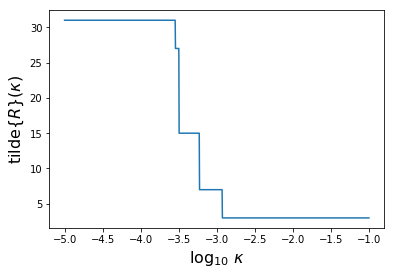

In [10]:
G = Graph(B.shape[0],3,adjacency_matrix=B)
listekappa = np.logspace(-5,-1,1000)
G.SCCHEi_with_R_search(listekappa=listekappa, figure=True)

### Code to reproduce exactly the figure shown in Section D of the Supplementary Material

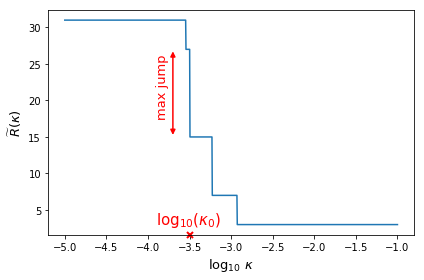

In [11]:
listekappa=np.logspace(-5,-1,1000)
listeR =None
G.compute_dimensions_sphere()
L = len(G.dimensions)
if listeR is None:
    listeR = [i for i in range(1,L)]
if listekappa is None:
    listekappa = np.logspace(-4,0,1000)
listeI = []
listeSpectra = []
for R in listeR:
    I, spectrumenv = G.SCCHEi(R)
    listeI.append(I)
    listeSpectra.append(spectrumenv)

listeI = np.array(listeI)
M = np.tile(listekappa.reshape(1,-1),(len(listeR),1))
M /= G.n
dims = np.array(G.dimensions)[listeR]
M *= np.tile(dims.reshape(-1,1),(1,len(listekappa)))
M += np.tile(listeI.reshape(-1,1),(1,len(listekappa)))
R_kappa = np.argmin(M, axis=0)
D_kappa = dims[R_kappa]
gap = -np.float('inf')
kappa0 = 0
bestI = 0
for i in range(len(listekappa)-1):
    newgap = D_kappa[i] - D_kappa[i+1]
    if newgap > gap:
        gap = newgap
        kappa0 = listekappa[i]
        bestI = i

crit = np.float('inf')
for i,R in enumerate(listeR):
    nextcrit = listeI[i] + 2*kappa0*dims[i]/G.n
    if crit > nextcrit:
        G.spectrumenv = listeSpectra[i]
        crit = nextcrit
from matplotlib.transforms import BlendedGenericTransform
if True:
    fig, ax = plt.subplots()
    ax.plot(np.log10(listekappa), D_kappa)
    ax.plot(np.log10(listekappa[bestI]), np.zeros_like(np.log10(listekappa[bestI])), 'rx', clip_on=False, mew=2, transform=BlendedGenericTransform(ax.transData, ax.transAxes))
    limits = np.array(ax.axis())
    ax.axis(limits)
    ax.text(-3.9,3, '$\log_{10}(\kappa_0)$',color='red', fontsize=15)
    ax.annotate('', xy=(-3.7, 27),
             xycoords='data',
             xytext=(-3.7, 15),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='red',
                             lw=1.5,
                             ls='-')
           )
    ax.text(-3.9, 25, 'max jump', 
         rotation = 90, color='red', fontsize = 13)
    ax.set_xlabel('$\log_{10}$ $\kappa$', fontsize=13)
    ax.set_ylabel('$\\widetilde{R}(\kappa)$', fontsize=13)
    plt.tight_layout()
    plt.savefig('slope-heuristic.png',dpi=300)

### Estimated envelope

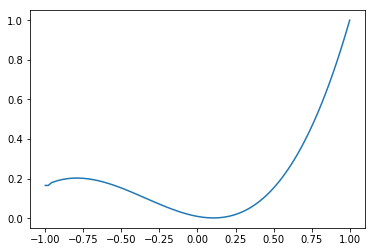

In [12]:
G.plot_estimation_envelope_real_data(savename='email-slope-envelope.png')

### Estimated Latitude function

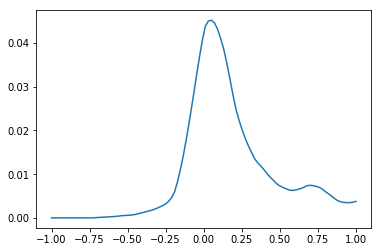

In [13]:
G.plot_density_latitude_real_data(percent=0.1,savename='email-slope-latitude.png')

# 7) Application on real data : Gowalla dataset (see Section F)


###### You can download the data at  https://snap.stanford.edu/data/loc-gowalla.html
###### You should  save the files from the above links in the folder 'data'.

In [ ]:
edges = []
with open('data/Gowalla_edges.txt') as f:
    content = f.readlines()
    fist = True
    for line in content:
        l = line.split('\t')
        edges.append([int(l[0]),int(l[1][:-1])])
edges = np.array(edges)

import datetime as date
   
checkin = []
with open('data/Gowalla_totalCheckins.txt') as f:
    content = f.readlines()
    for line in content:
        l = line.split('\t')[:2]
        timeformat = date.datetime.strptime(l[1][:-1],"%Y-%m-%dT%H:%M:%S")
        li = [int(l[0]),date.datetime.timestamp(timeformat)]
        checkin.append(li)

checkin = np.array(checkin)
checkin = checkin[np.argsort(checkin[:,1]),:]

order = []
ID = -1
for i in range(checkin.shape[0]):
    if checkin[i,0] != ID:
        order.append(checkin[i,0])
name2ID = {}
ID2name = {}
count = 0
for k in range(len(order)):
    if order[k] not in name2ID.keys():
        name2ID[order[k]] = count
        ID2name[count] = order[k]
        count += 1
n = len(name2ID)
rows = []
cols = []
data = []
for k in range(edges.shape[0]):
    try:
        i,j = name2ID[edges[k,0]], name2ID[edges[k,1]]
        rows.append(i)
        rows.append(j)
        cols.append(j)
        cols.append(i)
        data.append(1.0)
        data.append(1.0)
    except:
        pass

In [ ]:
A = sc.sparse.coo_matrix((data, (rows, cols)))
nbeigvals = 100
eig, vec = sc.sparse.linalg.eigsh(A, k=nbeigvals, which='LA')
dimension = 2
G = Graph(2*nbeigvals,dimension)
G.dec_eigs = eig[::-1]
G.SCCHEi_with_R_search()

###### Clustering eigenvalues

In [ ]:
G.plot_adjacency_eigs_vs_SCCHEi_clusters(2)

###### Envelope function

In [ ]:
x = np.linspace(-1,1,100)
G.esti = [G.estimation_enveloppe(xi)  for xi in x]
M = np.max(G.esti)
G.esti /= M
G.esti = list(map(lambda x:max(0,x),G.esti))
plt.plot(x, G.esti)
plt.title('Estimated envelope function')

###### Latitude function

In [ ]:
order = np.argsort(eig)[::-1]
V = vec[:,order[1:3]]
updiag = (V.shape[0] /G.d) * np.array([np.dot(V[i,:],V[i+1,:]) for i in range(V.shape[0]-1)])

from sklearn.neighbors import KernelDensity
L = updiag 
percent = 0.05
Labs = np.sort(np.abs(updiag))
size = percent * len(updiag)
normalize = Labs[int(size)]
L /= normalize
L = np.array(list(map(lambda x : min(max(-1,x),x),L))).reshape(-1,1)

kde = KernelDensity(kernel='linear', bandwidth=0.3).fit(L.reshape(-1,1))
x = np.linspace(-1,1,100)
log_dens = kde.score_samples(x.reshape(-1,1))
plt.plot(x, np.exp(log_dens)/sum(np.exp(log_dens)))
plt.title('Estimated latitude function')